Notebook written by David Shimshoni

Tic Tac Toe Environment (script renamed hajeTTTENV) created by Kim Jeong Ju, Dustin Michels, and Johann Miller, used here under the terms of the MIT License. Original work found here: https://github.com/haje01/gym-tictactoe

In [1]:
import os
import sys
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import gym

LOCAL_PATH = os.getcwd()
print(os.listdir(LOCAL_PATH))
sys.path.append(LOCAL_PATH)
sys.path.append(LOCAL_PATH + '/lib')

from hajeTTTEnv import *

['.ipynb_checkpoints', 'lib', 'TicTacToeProjectCode.ipynb', 'TicTacToeTrialRun.ipynb']


In [2]:
env = TicTacToeEnv()

In [3]:
## Note: By default environment assumes 'O' starts first. Has positive reward if this player wins
## The second mark, 'X', goes second, and has a negative reward for winning

def q_learning_const_epsilon_train(n_episodes=100000, visualize_env=False, print_output=False,
                        alpha=0.3, gamma=0.9, epsilon=0.1):
    
    ### Q-TABLE INITIALIZATION ### 

    ## Q-table is 10 dimensions, the first being the action space(9 rows).
    ## The remaining 9 dimensions are one of the three possible values of each square:
    ## 0 is blank, 1 is 'O', 2 is 'X'

    qlearn_Q = np.zeros((env.action_space.n, 
                         3, 3, 3, 
                         3, 3, 3, 
                         3, 3, 3))

    R_q_agent = [] # for collecting returns
    T_q_agent = [] # for collecting number of timesteps

    ## Determining who will start the first game
    start = random.uniform(0, 1)
    if start > 0.5:
        start_first= True
    else:
        start_first = False

    for i_episode in range(n_episodes):

        agent_turn = start_first

        if print_output:
            print('Episode: ' + str(i_episode+1))

        # Reset environment at the beginning of each episode. 
        observation, mark = env.reset()

        done = False

        t = 0 # timestep counter
        ep_return = 0 # return_counter

        available_actions = env.available_actions()

        # Loop through time steps. 
        while not done:

            if print_output:
                print('Timestep: ' + str(t+1))

            # Visualize state of the environment. 
            if visualize_env:
                env.render()
                print('\n ')

            if agent_turn:
                # Pick an action. (Agent's Turn)
                ############################ 

                explore = random.uniform(0, 1)

                if explore > epsilon:
                    if start_first:
                        
                        ## If starting first, agent is trying to maximize Q-value with action
                        ## (remember, second player's reward for winning is represented as negative by environment)
                        
                        action_index = np.argmax(qlearn_Q[available_actions, 
                                                         observation[0], observation[1], observation[2],
                                                         observation[3], observation[4], observation[5],
                                                         observation[6], observation[7], observation[8]])
                    else:
                        
                        ## If starting second, agent is trying to minimize Q-value with action
                        ## (remember, second player's reward for winning is represented as negative by environment)
                        
                        action_index = np.argmin(qlearn_Q[available_actions, 
                                                         observation[0], observation[1], observation[2],
                                                         observation[3], observation[4], observation[5],
                                                         observation[6], observation[7], observation[8]])
                    action = available_actions[action_index]
                else:
                    action = np.random.choice(available_actions)

                ############################ 
                
            # Random action. (Opponent's Turn)
            else:
                action = np.random.choice(available_actions)
            
            ############################ 
            
            if print_output:
                print('Action: ', action)

            ### STEP FUNCTION ###

            (next_observation, next_mark), reward, done, info = env.step(action)
            available_actions = env.available_actions()
            
            ### Q-VALUE UPDATE ###

            try:
                if start_first:
                    next_obs_Q = qlearn_Q[available_actions[np.argmax(qlearn_Q[available_actions, 
                                                         next_observation[0], next_observation[1], next_observation[2],
                                                         next_observation[3], next_observation[4], next_observation[5],
                                                         next_observation[6], next_observation[7], next_observation[8]])], 
                                      next_observation[0], next_observation[1], next_observation[2],
                                      next_observation[3], next_observation[4], next_observation[5],
                                      next_observation[6], next_observation[7], next_observation[8]]
                else:
                    next_obs_Q = qlearn_Q[available_actions[np.argmin(qlearn_Q[available_actions, 
                                                         next_observation[0], next_observation[1], next_observation[2],
                                                         next_observation[3], next_observation[4], next_observation[5],
                                                         next_observation[6], next_observation[7], next_observation[8]])], 
                                      next_observation[0], next_observation[1], next_observation[2],
                                      next_observation[3], next_observation[4], next_observation[5],
                                      next_observation[6], next_observation[7], next_observation[8]]

            except ValueError:
                next_obs_Q = 0
                
            old_Q = qlearn_Q[action, 
                            observation[0], observation[1], observation[2],
                            observation[3], observation[4], observation[5],
                            observation[6], observation[7], observation[8]]
            updated_Q = old_Q + alpha * (reward + gamma * next_obs_Q - old_Q)

            qlearn_Q[action, 
                    observation[0], observation[1], observation[2],
                    observation[3], observation[4], observation[5],
                    observation[6], observation[7], observation[8]] = updated_Q
            observation = next_observation
            mark = next_mark

            # Update counters.
            
            if start_first:
                ep_return += reward
            else:
                ## Reprsenting episode return as opposite sign if player start second
                ep_return -= reward

            t += 1
            
            ## Shifting to the next player's turn
            agent_turn = not agent_turn

            if print_output:
                print('Reward: ' + str(reward))

            # Check if we reached the terminal state. 
            
            if done:
                ## Appending reward and timestep for this episode
                R_q_agent.append(ep_return)
                T_q_agent.append(t)
                
                ## Alternating the starting player for next episode
                start_first = not start_first
                break

        if print_output:
            print("Timesteps taken: {}".format(t))
            print("Episode return: {}".format(ep_return))

    env.close()
    return qlearn_Q, R_q_agent, T_q_agent

In [4]:
def q_learning_decay_epsilon_train(n_episodes=100000, visualize_env=False, print_output=False,
                        alpha=0.3, gamma=0.9, epsilon_func=np.reciprocal):
    
    ### Q-TABLE INITIALIZATION ### 

    ## Q-table is 10 dimensions, the first being the action space(9 rows).
    ## The remaining 9 dimensions are one of the three possible values of each square:
    ## 0 is blank, 1 is 'O', 2 is 'X'

    qlearn_Q = np.zeros((env.action_space.n, 
                         3, 3, 3, 
                         3, 3, 3, 
                         3, 3, 3))

    R_q_agent = [] # for collecting returns
    T_q_agent = [] # for collecting number of timesteps

    ## Determining who will start the first game
    start = random.uniform(0, 1)
    if start > 0.5:
        start_first= True
    else:
        start_first = False

    for i_episode in range(n_episodes):
        
        ## Calculating the decaying epsilon
        epsilon = epsilon_func(1.0+i_episode)

        agent_turn = start_first

        if print_output:
            print('Episode: ' + str(i_episode+1))

        # Reset environment at the beginning of each episode. 
        observation, mark = env.reset()

        done = False

        t = 0 # timestep counter
        ep_return = 0 # return_counter

        available_actions = env.available_actions()

        # Loop through time steps. 
        while not done:

            if print_output:
                print('Timestep: ' + str(t+1))

            # Visualize state of the environment. 
            if visualize_env:
                env.render()
                print('\n ')

            if agent_turn:
                # Pick an action. (Agent's Turn)
                ############################ 

                explore = random.uniform(0, 1)

                if explore > epsilon:
                    if start_first:
                        
                        ## If starting first, agent is trying to maximize Q-value with action
                        ## (remember, second player's reward for winning is represented as negative by environment)
                        
                        action_index = np.argmax(qlearn_Q[available_actions, 
                                                         observation[0], observation[1], observation[2],
                                                         observation[3], observation[4], observation[5],
                                                         observation[6], observation[7], observation[8]])
                    else:
                        
                        ## If starting second, agent is trying to minimize Q-value with action
                        ## (remember, second player's reward for winning is represented as negative by environment)
                        
                        action_index = np.argmin(qlearn_Q[available_actions, 
                                                         observation[0], observation[1], observation[2],
                                                         observation[3], observation[4], observation[5],
                                                         observation[6], observation[7], observation[8]])
                    action = available_actions[action_index]
                else:
                    action = np.random.choice(available_actions)

                ############################ 
                
            # Random action. (Opponent's Turn)
            else:
                action = np.random.choice(available_actions)
            
            ############################ 
            
            if print_output:
                print('Action: ', action)

            ### STEP FUNCTION ###

            (next_observation, next_mark), reward, done, info = env.step(action)
            available_actions = env.available_actions()
            
            ### Q-VALUE UPDATE ###

            try:
                if start_first:
                    next_obs_Q = qlearn_Q[available_actions[np.argmax(qlearn_Q[available_actions, 
                                                         next_observation[0], next_observation[1], next_observation[2],
                                                         next_observation[3], next_observation[4], next_observation[5],
                                                         next_observation[6], next_observation[7], next_observation[8]])], 
                                      next_observation[0], next_observation[1], next_observation[2],
                                      next_observation[3], next_observation[4], next_observation[5],
                                      next_observation[6], next_observation[7], next_observation[8]]
                else:
                    next_obs_Q = qlearn_Q[available_actions[np.argmin(qlearn_Q[available_actions, 
                                                         next_observation[0], next_observation[1], next_observation[2],
                                                         next_observation[3], next_observation[4], next_observation[5],
                                                         next_observation[6], next_observation[7], next_observation[8]])], 
                                      next_observation[0], next_observation[1], next_observation[2],
                                      next_observation[3], next_observation[4], next_observation[5],
                                      next_observation[6], next_observation[7], next_observation[8]]

            except ValueError:
                next_obs_Q = 0
                
            old_Q = qlearn_Q[action, 
                            observation[0], observation[1], observation[2],
                            observation[3], observation[4], observation[5],
                            observation[6], observation[7], observation[8]]
            updated_Q = old_Q + alpha * (reward + gamma * next_obs_Q - old_Q)

            qlearn_Q[action, 
                    observation[0], observation[1], observation[2],
                    observation[3], observation[4], observation[5],
                    observation[6], observation[7], observation[8]] = updated_Q
            observation = next_observation
            mark = next_mark

            # Update counters.
            
            if start_first:
                ep_return += reward
            else:
                ## Reprsenting episode return as opposite sign if player start second
                ep_return -= reward

            t += 1
            
            ## Shifting to the next player's turn
            agent_turn = not agent_turn

            if print_output:
                print('Reward: ' + str(reward))

            # Check if we reached the terminal state. 
            
            if done:
                ## Appending reward and timestep for this episode
                R_q_agent.append(ep_return)
                T_q_agent.append(t)
                
                ## Alternating the starting player for next episode
                start_first = not start_first
                break

        if print_output:
            print("Timesteps taken: {}".format(t))
            print("Episode return: {}".format(ep_return))

    env.close()
    return qlearn_Q, R_q_agent, T_q_agent

In [5]:
## Calculates and returns an agent's win rate for every num_games
def win_rate_calculator(reward_array, num_games=100):
    
    win_rate_list = []
    
    for i in range(0, len(reward_array)-1, num_games):
        win_rate = np.sum(reward_array[i:i+num_games] == 1) / num_games
        win_rate_list.append(win_rate)
        
    return win_rate_list

## Calculates and returns an agent's win rate in the last 1000 games
def last_thousand_win_rate(reward_array):
    
    win_rate = np.sum(reward_array[-1000:] == 1) / 1000
    
    return win_rate

In [6]:
const_epsilons = [0.05, 0.1, 0.2]
results = {}

for epsilon in const_epsilons:
    results[epsilon] = {}
    train_results = q_learning_const_epsilon_train(epsilon=epsilon)
    results[epsilon]["q_table"] = train_results[0]
    results[epsilon]["reward"] = np.array(train_results[1])
    results[epsilon]["timesteps"] = np.array(train_results[2])
    results[epsilon]["win_rate_over_time"] = win_rate_calculator(results[epsilon]["reward"])
    results[epsilon]["last_thousand_win_rate"] = last_thousand_win_rate(results[epsilon]["reward"])

In [7]:
decaying_epsilon_functions = {"reciprocal": np.reciprocal, 
                              "reciprocal_square_root": lambda x: np.reciprocal(np.sqrt(x)), 
                              "reciprocal_nat_log": lambda x: np.reciprocal(np.log(x - 1 + np.e))}

for func_name, epsilon_function in decaying_epsilon_functions.items():
    results[func_name] = {}
    train_results = q_learning_decay_epsilon_train(epsilon_func=epsilon_function)
    results[func_name]["q_table"] = train_results[0]
    results[func_name]["reward"] = np.array(train_results[1])
    results[func_name]["timesteps"] = np.array(train_results[2])
    results[func_name]["win_rate_over_time"] = win_rate_calculator(results[func_name]["reward"])
    results[func_name]["last_thousand_win_rate"] = last_thousand_win_rate(results[func_name]["reward"])

In [8]:
for epsilon in results.keys():
    print("The win rate in the last thousand games for the epsilon setting {} is {}".format(epsilon,
                                                                                           results[epsilon]["last_thousand_win_rate"]))

The win rate in the last thousand games for the epsilon setting 0.05 is 0.779
The win rate in the last thousand games for the epsilon setting 0.1 is 0.807
The win rate in the last thousand games for the epsilon setting 0.2 is 0.767
The win rate in the last thousand games for the epsilon setting reciprocal is 0.7
The win rate in the last thousand games for the epsilon setting reciprocal_square_root is 0.777
The win rate in the last thousand games for the epsilon setting reciprocal_nat_log is 0.827


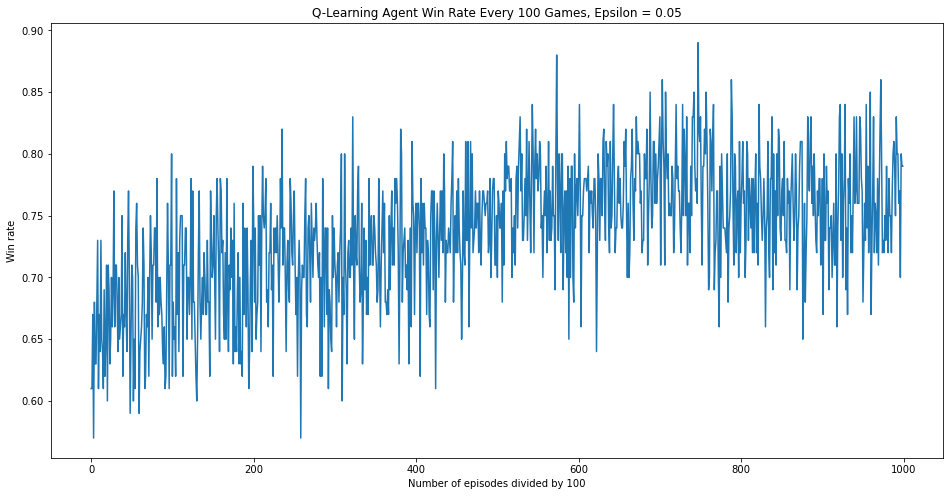

In [9]:
plt.figure(figsize=[16, 8])
plt.plot(results[0.05]["win_rate_over_time"])
plt.title("Q-Learning Agent Win Rate Every 100 Games, Epsilon = 0.05")
plt.xlabel("Number of episodes divided by 100")
plt.ylabel("Win rate")
plt.show()

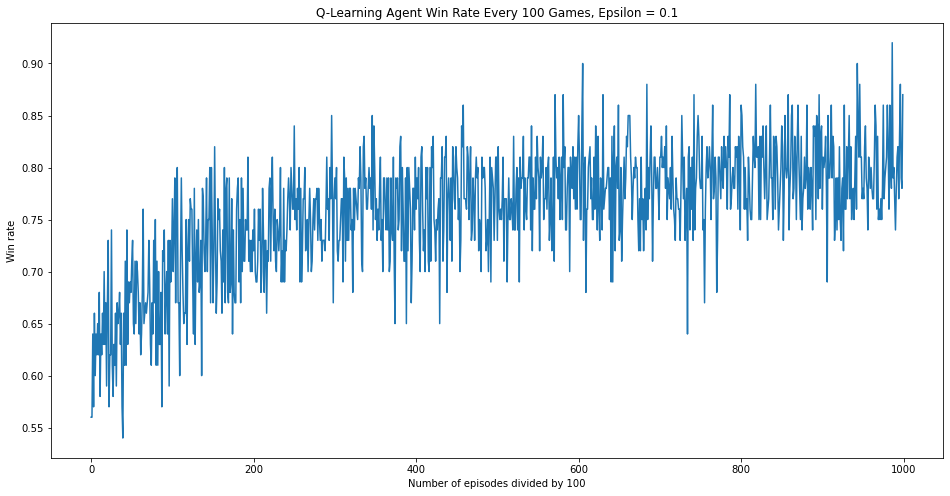

In [10]:
plt.figure(figsize=[16, 8])
plt.plot(results[0.1]["win_rate_over_time"])
plt.title("Q-Learning Agent Win Rate Every 100 Games, Epsilon = 0.1")
plt.xlabel("Number of episodes divided by 100")
plt.ylabel("Win rate")
plt.show()

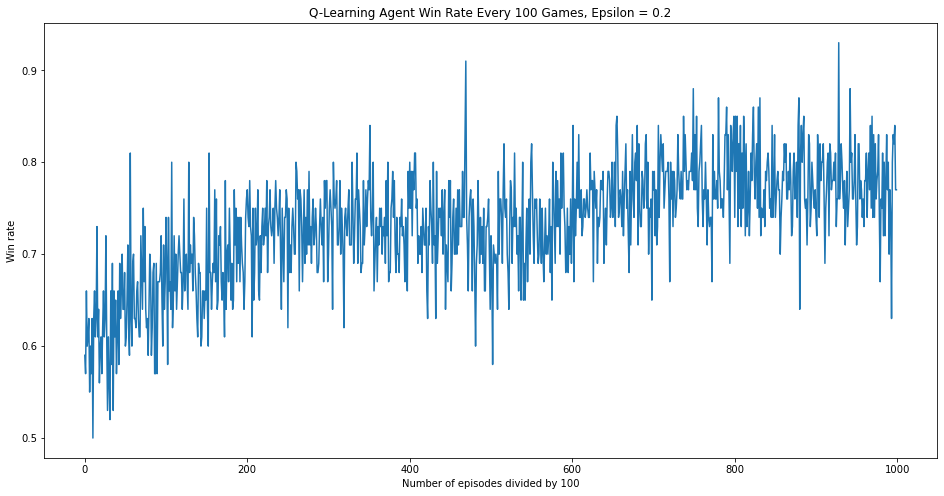

In [11]:
plt.figure(figsize=[16, 8])
plt.plot(results[0.2]["win_rate_over_time"])
plt.title("Q-Learning Agent Win Rate Every 100 Games, Epsilon = 0.2")
plt.xlabel("Number of episodes divided by 100")
plt.ylabel("Win rate")
plt.show()

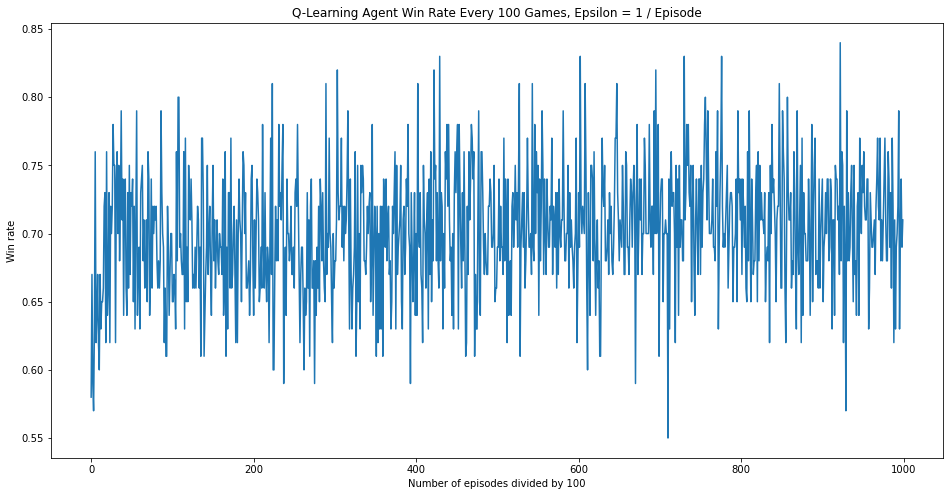

In [12]:
plt.figure(figsize=[16, 8])
plt.plot(results["reciprocal"]["win_rate_over_time"])
plt.title("Q-Learning Agent Win Rate Every 100 Games, Epsilon = 1 / Episode")
plt.xlabel("Number of episodes divided by 100")
plt.ylabel("Win rate")
plt.show()

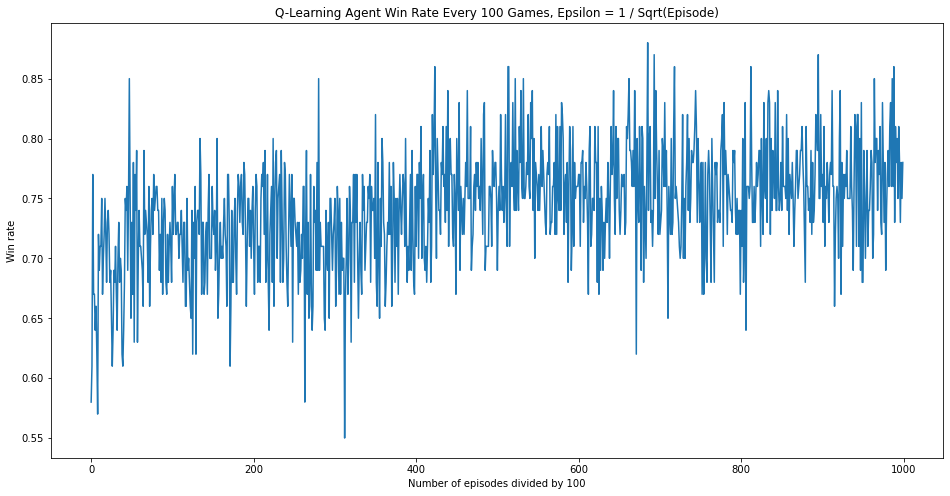

In [13]:
plt.figure(figsize=[16, 8])
plt.plot(results["reciprocal_square_root"]["win_rate_over_time"])
plt.title("Q-Learning Agent Win Rate Every 100 Games, Epsilon = 1 / Sqrt(Episode)")
plt.xlabel("Number of episodes divided by 100")
plt.ylabel("Win rate")
plt.show()

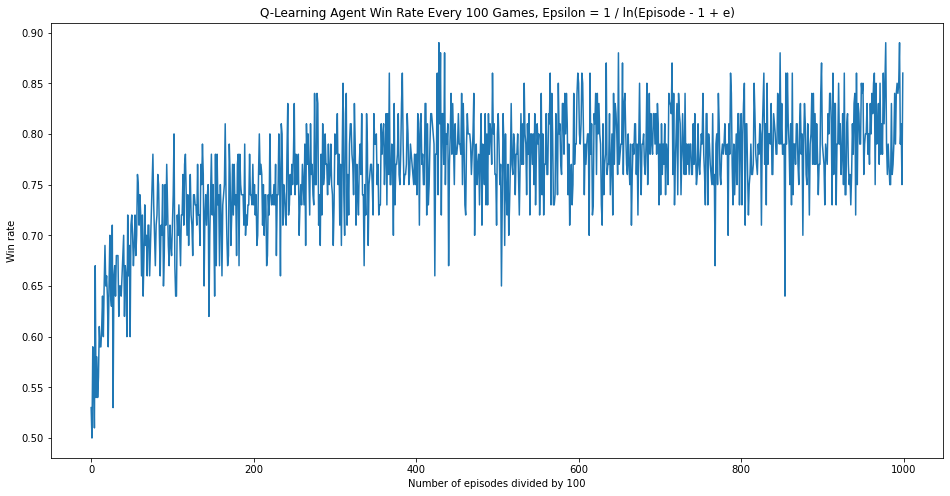

In [14]:
plt.figure(figsize=[16, 8])
plt.plot(results["reciprocal_nat_log"]["win_rate_over_time"])
plt.title("Q-Learning Agent Win Rate Every 100 Games, Epsilon = 1 / ln(Episode - 1 + e)")
plt.xlabel("Number of episodes divided by 100")
plt.ylabel("Win rate")
plt.show()